In [1]:
import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from std_msgs.msg import Float64
from dynamixel_sdk import *
import datetime
import threading
import serial
import re
import pandas as pd
import glob


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_21005/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [4]:
class Dynamixel_motor:
    def __init__(self, dxl_id, baudrate, device_name):
        self.dxl_id = dxl_id
        self.baudrate = baudrate
        self.device_name = device_name
        self.protocol_version = 2.0

        # Initialize PortHandler instance
        # Set the port path
        # Get methods and members of PortHandlerLinux or PortHandlerWindows
        self.portHandler = PortHandler(self.device_name)

        # Initialize PacketHandler instance
        # Set the protocol version
        # Get methods and members of Protocol1PacketHandler or Protocol2PacketHandler
        self.packetHandler = PacketHandler(self.protocol_version)

        # Open port
        if self.portHandler.openPort():
            print("Succeeded to open the port")
        else:
            print("Failed to open the port")
            print("Press any key to terminate...")
            self.close_port()

        # Set port baudrate
        if self.portHandler.setBaudRate(self.baudrate):
            print("Succeeded to change the baudrate")
        else:
            print("Failed to change the baudrate")
            print("Press any key to terminate...")
            self.close_port()

    def __del__(self):
        print('Destructor called.')
        self.portHandler.closePort()

    def close_port(self):
        self.torque_disable()
        self.portHandler.closePort()
        print('closing port.')

    def ping_motor(self):

        # Try to ping the Dynamixel
        # Get Dynamixel model number
        dxl_model_number, dxl_comm_result, dxl_error = self.packetHandler.ping(self.portHandler, self.dxl_id)
        print(f"dxl_model_number is: {dxl_model_number}")
        print(f"dxl_comm_result is: {dxl_comm_result}")
        print(f"dxl_error is: {dxl_error}")
        print(f"COMM_SUCCESS is {COMM_SUCCESS}")
        if dxl_comm_result != COMM_SUCCESS:
            print("statement 0")
            print("%s" % self.packetHandler.getTxRxResult(dxl_comm_result))
            self.close_port()
        elif dxl_error != 0:
            print("statement 1")
            print("%s" % self.packetHandler.getRxPacketError(dxl_error))
            self.close_port()
        else:
            print("statement 2")
            print("[ID:%03d] ping Succeeded. Dynamixel model number : %d" % (self.dxl_id, dxl_model_number))

    def torque_enable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 1
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def torque_disable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 0
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def read_operation_mode(self):
        OPERATING_MODE_REG = 11
        data, result, error = self.packetHandler.read1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG)
        print(f"data is: {data}")
        print(f"result is: {result}")
        print(f"error is: {error}")
        return data

    def set_current_position_mode(self):
        OPERATING_MODE_REG = 11
        OPERATION_MODE = 5
        result, error = self.packetHandler.write1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG, OPERATION_MODE)
        return

    def set_goal_current(self, GOAL_CURRENT):
        GOAL_CURRENT_REG = 102
        result, error = self.packetHandler.write2ByteTxRx(self.portHandler, self.dxl_id, GOAL_CURRENT_REG, GOAL_CURRENT)
        return

    def read_present_position(self):
        PRESENT_POSITION_REG = 132
        PRESENT_POSITION, result, error = self.packetHandler.read4ByteTxRx(self.portHandler, self.dxl_id, PRESENT_POSITION_REG)
        return PRESENT_POSITION

    def set_goal_position(self, GOAL_POSITION):
        GOAL_POSITION_REG = 116
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, GOAL_POSITION_REG, GOAL_POSITION)
        return

    def read_present_current(self):
        PRESENT_CURRENT_REG = 126
        PRESENT_CURRENT, result, error = self.packetHandler.read2ByteTxRx(self.portHandler, self.dxl_id, PRESENT_CURRENT_REG)
        return PRESENT_CURRENT


Succeeded to open the port
Succeeded to change the baudrate
data is: 5
result is: 0
error is: 0
[INFO] [1677365048.793171]: Timing images
Enter something: 
b'000.0,000.0,0000.0,0000.0\r\n'
[INFO] [1677365055.870574]: Image received...


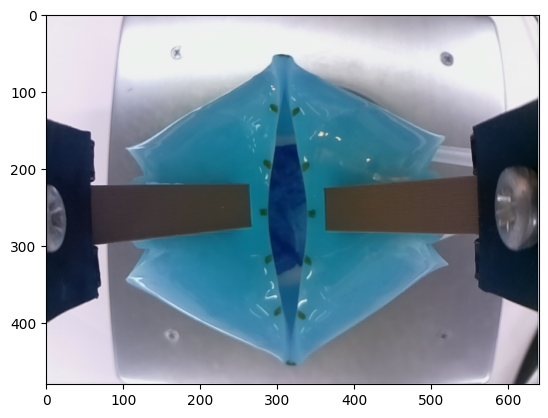

b'064.9,051.3,0249.8,0250.3\r\n'
Data number 1
['064.9', '051.3', '0249.8', '0250.3']
b'063.0,053.1,0325.9,0160.6\r\n'
['063.0', '053.1', '0325.9', '0160.6']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677365073.881958]: Image received...


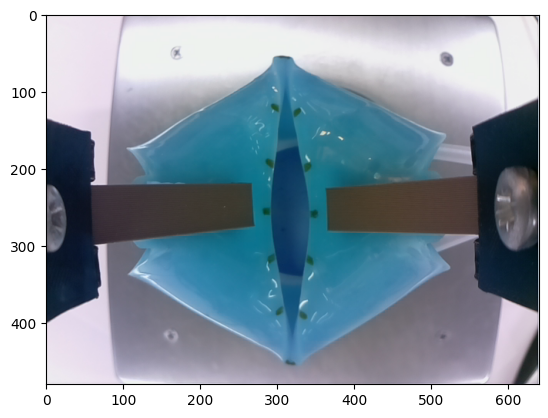

b'052.5,050.6,0250.0,0251.2\r\n'
Data number 2
['052.5', '050.6', '0250.0', '0251.2']
b'049.9,047.8,0349.9,0164.6\r\n'
['049.9', '047.8', '0349.9', '0164.6']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677365092.615083]: Image received...


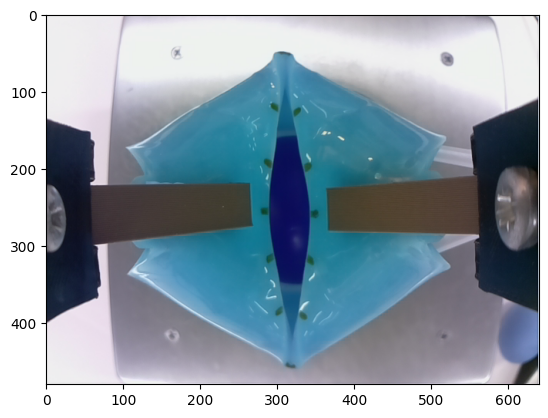

b'066.1,057.3,0284.2,0284.8\r\n'
Data number 3
['066.1', '057.3', '0284.2', '0284.8']
b'062.8,056.4,0386.5,0189.5\r\n'
['062.8', '056.4', '0386.5', '0189.5']
Enter something: 
b'000.0,000.0,0000.3,0000.2\r\n'
[INFO] [1677365110.121651]: Image received...


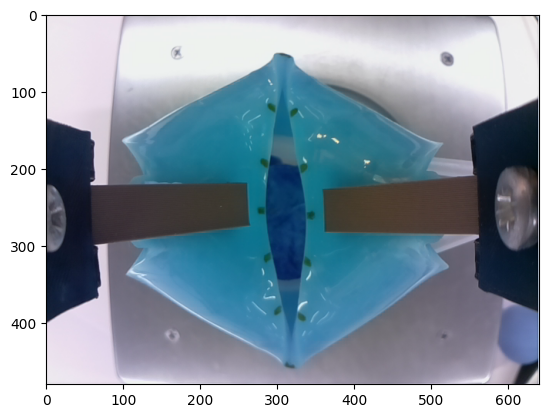

b'035.3,072.0,0281.3,0283.4\r\n'
Data number 4
['035.3', '072.0', '0281.3', '0283.4']
b'037.8,066.4,0352.8,0187.6\r\n'
['037.8', '066.4', '0352.8', '0187.6']
Enter something: 
b'000.0,000.0,0000.4,0000.4\r\n'
[INFO] [1677365126.610741]: Image received...


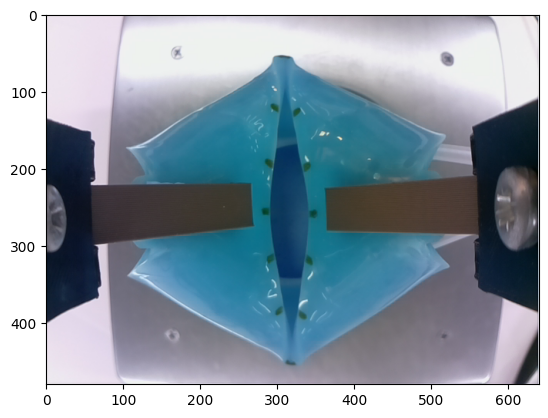

b'048.6,048.0,0256.7,0258.2\r\n'
Data number 5
['048.6', '048.0', '0256.7', '0258.2']
b'046.1,045.9,0355.6,0170.4\r\n'
['046.1', '045.9', '0355.6', '0170.4']
Enter something: 
b'000.0,000.0,0000.2,0000.3\r\n'
[INFO] [1677365146.118682]: Image received...


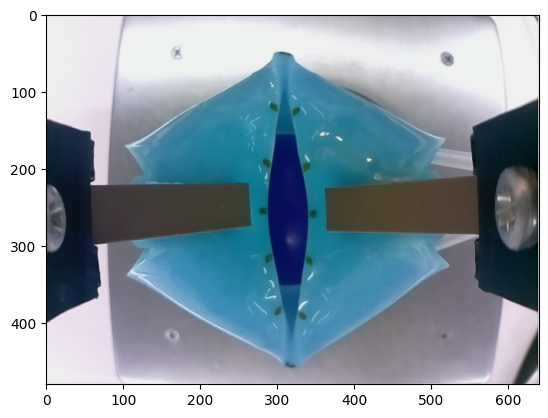

b'057.2,054.2,0281.2,0282.3\r\n'
Data number 6
['057.2', '054.2', '0281.2', '0282.3']
b'053.5,052.6,0380.8,0184.2\r\n'
['053.5', '052.6', '0380.8', '0184.2']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677365165.101848]: Image received...


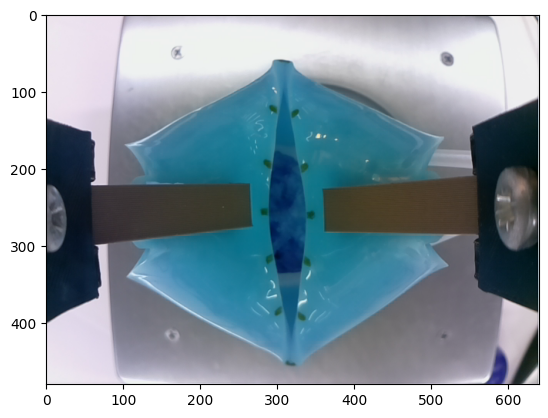

b'047.0,062.1,0241.4,0241.3\r\n'
Data number 7
['047.0', '062.1', '0241.4', '0241.3']
b'047.5,059.3,0322.8,0157.5\r\n'
['047.5', '059.3', '0322.8', '0157.5']
Enter something: 
b'000.0,000.0,0001.1,000-0.1\r\n'
[INFO] [1677365183.114290]: Image received...


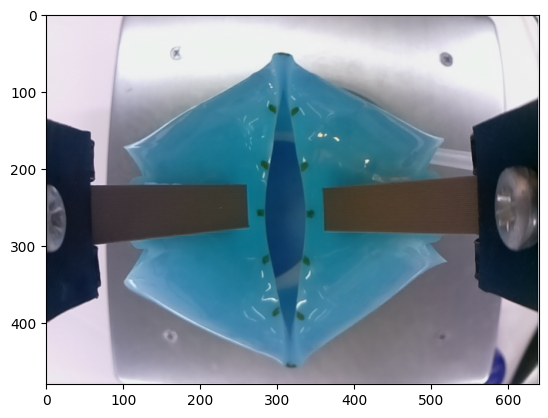

b'061.7,059.4,0279.7,0280.6\r\n'
Data number 8
['061.7', '059.4', '0279.7', '0280.6']
b'057.2,058.2,0366.7,0181.2\r\n'
['057.2', '058.2', '0366.7', '0181.2']
Enter something: 
b'000.0,000.0,0000.2,0000.3\r\n'
[INFO] [1677365201.336349]: Image received...


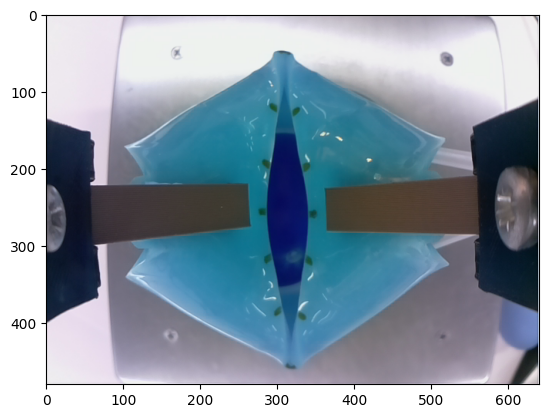

b'063.2,054.1,0296.4,0298.9\r\n'
Data number 9
['063.2', '054.1', '0296.4', '0298.9']
b'062.2,053.8,0395.5,0198.8\r\n'
['062.2', '053.8', '0395.5', '0198.8']
Enter something: 
b'000.0,000.0,0000.1,0000.1\r\n'
[INFO] [1677365219.865343]: Image received...


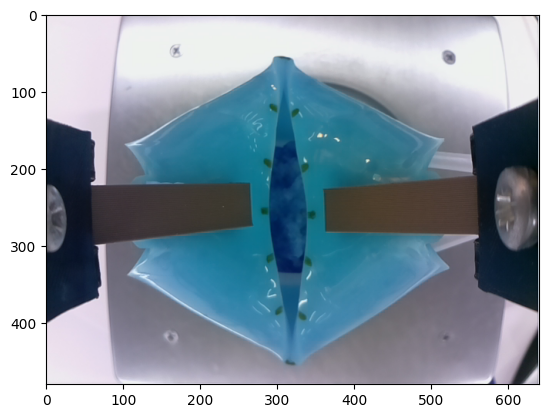

b'042.3,061.7,0252.5,0254.0\r\n'
Data number 10
['042.3', '061.7', '0252.5', '0254.0']
b'037.8,059.2,0333.7,0168.7\r\n'
['037.8', '059.2', '0333.7', '0168.7']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677365236.624373]: Image received...


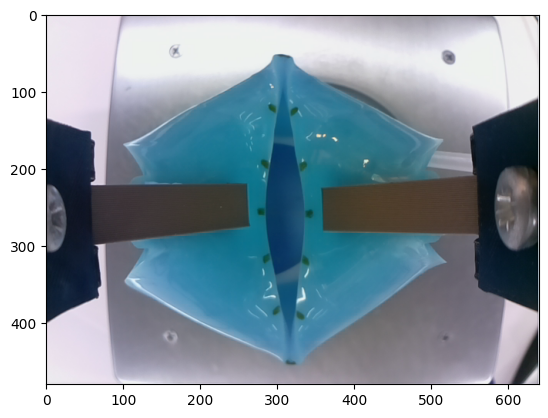

b'052.2,054.5,0262.7,0264.0\r\n'
Data number 11
['052.2', '054.5', '0262.7', '0264.0']
b'046.7,052.6,0350.8,0165.8\r\n'
['046.7', '052.6', '0350.8', '0165.8']
Enter something: 
b'000.0,000.0,0000.1,0000.2\r\n'
[INFO] [1677365256.870758]: Image received...


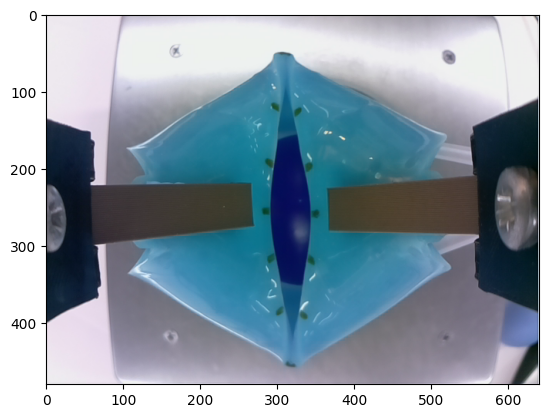

b'052.9,053.2,0280.0,0281.7\r\n'
Data number 12
['052.9', '053.2', '0280.0', '0281.7']
b'051.9,051.9,0384.7,0188.2\r\n'
['051.9', '051.9', '0384.7', '0188.2']
Enter something: 
b'000.0,000.0,0000.5,0000.5\r\n'
[INFO] [1677365272.864087]: Image received...


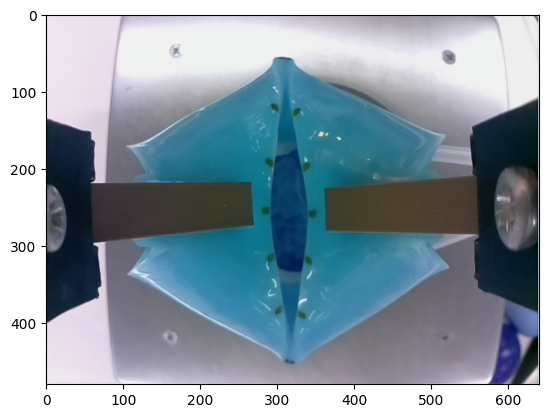

b'045.7,054.7,0249.6,0251.4\r\n'
Data number 13
['045.7', '054.7', '0249.6', '0251.4']
b'047.0,053.2,0335.9,0170.8\r\n'
['047.0', '053.2', '0335.9', '0170.8']
Enter something: 
b'000.0,000.0,0000.5,0000.5\r\n'
[INFO] [1677365289.605574]: Image received...


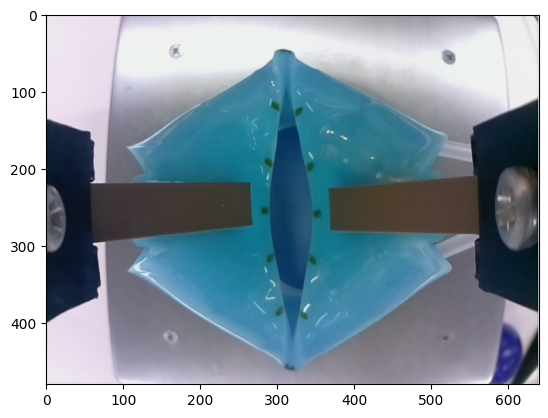

b'041.3,034.5,0314.6,0316.4\r\n'
Data number 14
['041.3', '034.5', '0314.6', '0316.4']
b'041.2,034.4,0412.2,0227.0\r\n'
['041.2', '034.4', '0412.2', '0227.0']
Enter something: 
b'000.0,000.0,0000.2,0000.3\r\n'
[INFO] [1677365308.619648]: Image received...


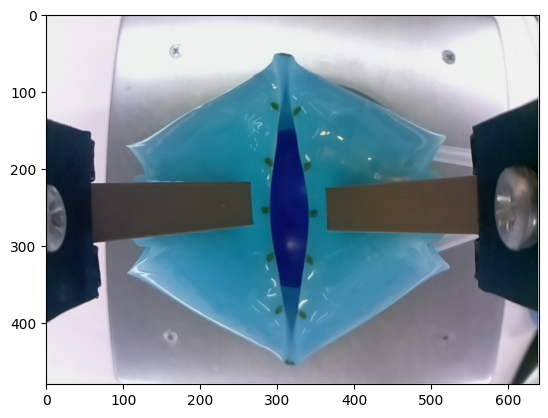

b'038.8,040.4,0263.5,0266.0\r\n'
Data number 15
['038.8', '040.4', '0263.5', '0266.0']
b'038.2,038.6,0367.4,0170.9\r\n'
['038.2', '038.6', '0367.4', '0170.9']
Enter something: 
b'000.0,000.0,0000.3,0000.3\r\n'
[INFO] [1677365325.868910]: Image received...


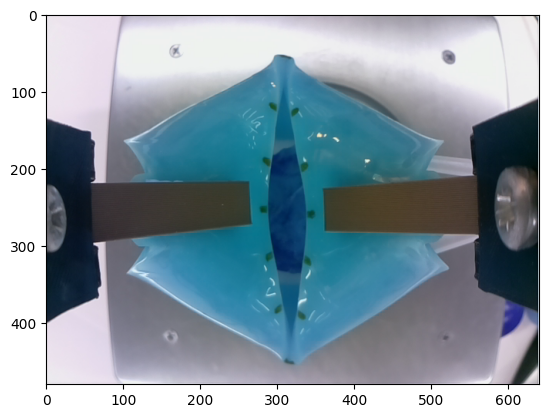

b'065.7,047.1,0258.0,0259.3\r\n'
Data number 16
['065.7', '047.1', '0258.0', '0259.3']
b'056.2,045.6,0339.4,0174.4\r\n'
['056.2', '045.6', '0339.4', '0174.4']
Enter something: 
b'000.0,000.0,0000.3,0000.4\r\n'
[INFO] [1677365343.368410]: Image received...


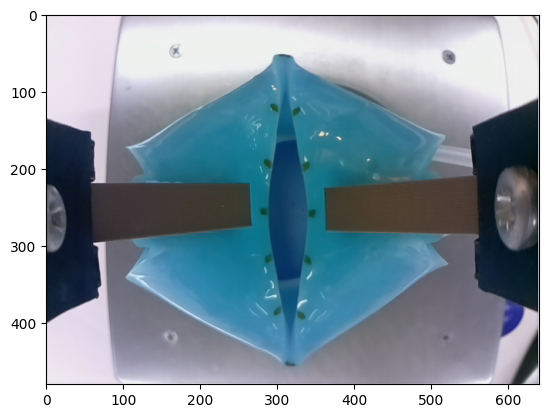

b'041.2,052.3,0269.4,0269.9\r\n'
Data number 17
['041.2', '052.3', '0269.4', '0269.9']
b'039.9,050.7,0364.3,0179.1\r\n'
['039.9', '050.7', '0364.3', '0179.1']
Enter something: 
b'000.0,000.0,0000.3,0000.2\r\n'
[INFO] [1677365361.617094]: Image received...


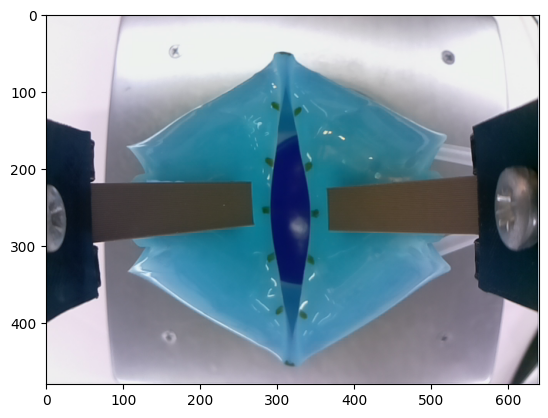

b'044.3,043.4,0277.6,0279.4\r\n'
Data number 18
['044.3', '043.4', '0277.6', '0279.4']
b'045.8,043.9,0383.6,0186.8\r\n'
['045.8', '043.9', '0383.6', '0186.8']


In [5]:
class Nodo(object):
    def __init__(self, dxl_motor):
        
        self.state = 0
        
        self.input_thread = threading.Thread(target=self.get_input)
        self.input_thread.daemon = True
        self.input_thread.start()
        
        self.image_array = []
        self.pressure_reading_1 = []
        self.pressure_reading_2 = []
        self.force_reading_1 = []
        self.force_reading_2 = []
        self.weight_reading_1 = []
        self.weight_reading_2 = []
        
        self.command = '0'
        self.take_photo = '0'
        self.dxl_motor = dxl_motor
        self.initialise_motor()
        
        self.ser = serial.Serial('/dev/ttyACM0', 57600, timeout=1)
        self.initialise_arduino()
        
        self.br = CvBridge()

        self.loop_rate = rospy.Rate(4)

        # Publishers
        self.pub = rospy.Publisher('number_command', Float64, queue_size=10)

        # Subscribers
        rospy.Subscriber("/image_capture",Image,self.callback)
    
    def initialise_arduino(self):
        time.sleep(2) # wait for the arduino to initialise
        self.ser.read(200) # clear the serial buffer
    
    def untare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'0')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def tare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'1')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'2')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def initialise_motor(self):
        self.dxl_motor.set_current_position_mode()
        self.dxl_motor.read_operation_mode()
        self.dxl_motor.set_goal_current(50)
        
    def move_jaw(self, position):
        self.dxl_motor.torque_enable()
#         print(f"current position is {self.dxl_motor.read_present_position()}")
        self.dxl_motor.set_goal_position(position)
    
    def disable_jaw(self):
        self.dxl_motor.torque_disable()
    
    def get_input(self):
        while True:
            self.command = input("Enter something: ")
            time.sleep(1)
    
    def callback(self, msg):
        rospy.loginfo('Image received...')
        self.image = self.br.imgmsg_to_cv2(msg)
        self.image_array.append(self.image)
        plt.imshow(self.image)
        plt.show()
    
    def store_arduino_data(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.pressure_reading_1.append(float(text[0]))
        self.pressure_reading_2.append(float(text[1]))
        self.force_reading_1.append(float(text[2]))
        self.force_reading_2.append(float(text[3]))
    
    def store_arduino_data_weight(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.weight_reading_1.append(float(text[2]))
        self.weight_reading_2.append(float(text[3]))
    
    def save_data(self):
        image_name = []
        directory = './Grasp_dataset_4/Grasp_dataset_test_2/'
        
        start_number = 0
        
        for i in range(0, len(self.image_array)):
            image_name.append('Teimage' + str(i+start_number).zfill(3) + '.jpg')
            cv2.imwrite(directory +'Teimage' + str(i+start_number).zfill(3) + '.jpg', my_node.image_array[i])
        
        header = ['image_name', 'weight_reading_1', 'weight_reading_2', 'pressure_reading_1', 'pressure_reading_2', 'force_reading_1', 'force_reading_2', 'label']
        grasp_df = pd.concat([pd.Series(image_name), pd.Series(self.weight_reading_1), pd.Series(self.weight_reading_2), pd.Series(self.pressure_reading_1), pd.Series(self.pressure_reading_2), pd.Series(self.force_reading_1), pd.Series(self.force_reading_2), pd.Series(np.repeat('test', len(self.image_array)))], axis=1, keys=header)
        
        combined_df_set = pd.read_csv(directory + 'Grasp_dataset_test_2.csv')
        
        combined_df_set = pd.concat([combined_df_set, grasp_df], axis=0)
        
        combined_df_set.to_csv(directory + 'Grasp_dataset_test_2.csv', index=False)
        
    def start(self):
        rospy.loginfo("Timing images")

        while not rospy.is_shutdown():
            
            if self.command == '':
                self.command = '0'
                print(self.tare_read_arduino())
                time.sleep(0.5)
                self.move_jaw(1900)
                time.sleep(1.6)
                self.pub.publish(5201314)
                data = self.read_arduino()
                print(data)
                print('Data number ' + str(len(self.image_array)))
                self.store_arduino_data(data)
                time.sleep(0.5)

                time.sleep(1.9)
                self.pub.publish(1314)
                data = self.read_arduino()
                print(data)
                self.store_arduino_data_weight(data)
                time.sleep(2.8)
                self.move_jaw(200)

            elif self.command == '3':
                self.disable_jaw()
        
            self.loop_rate.sleep()

if __name__ == '__main__':
    rospy.init_node("command_publisher", anonymous=True)
    dxl_motor = Dynamixel_motor(1, 57600, '/dev/ttyUSB0')
    my_node = Nodo(dxl_motor)
    my_node.start()

In [6]:
my_node.save_data()